# Preparation

## Import all the important packages

In [1]:
# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# seaborn, because of excellent heatmaps
import seaborn as sns;
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
# can also use sklearn for our regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import norm
from sklearn import tree
from sklearn.model_selection import GridSearchCV, PredefinedSplit

## Standardisation function

In [2]:
def standardise(data, mu=None, sigma=None):
    # return data, mu, sigma

    if mu is None:
        mu = np.mean(data, axis=0)
    if sigma is None:
        sigma = np.std(data, axis=0)
        
    scaled = (data - mu) / sigma
    return scaled, mu, sigma

Data shape:
(198, 28) (164, 28) (161, 28)


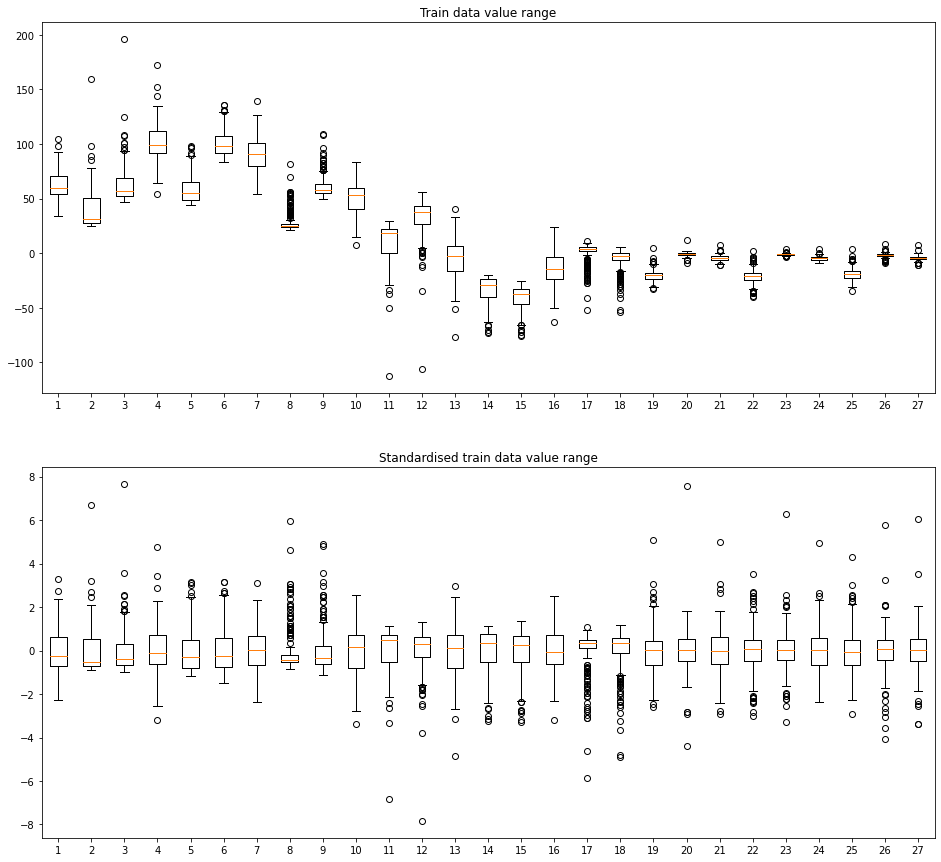

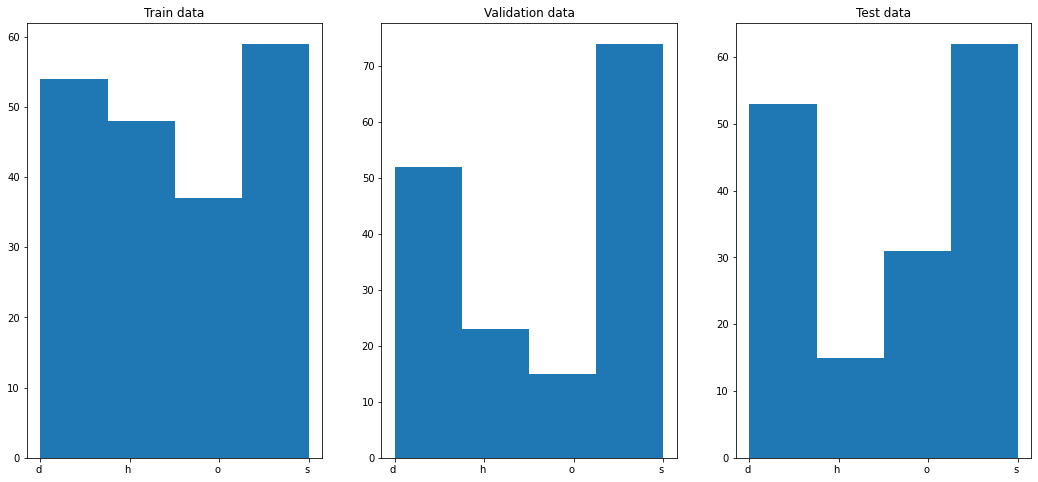

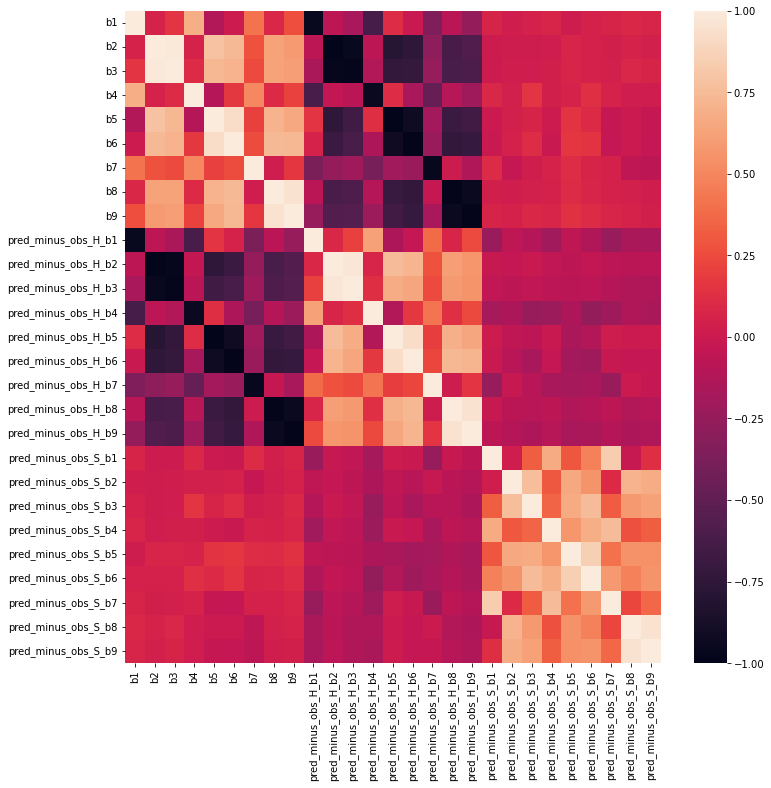

In [3]:
train_data = pd.read_csv('Data/Q2/training.csv')
val_data = pd.read_csv('Data/Q2/validation.csv')
test_data = pd.read_csv('Data/Q2/testing.csv')
train_data['class'] = pd.Categorical(train_data['class'])
val_data['class'] = pd.Categorical(val_data['class'])
test_data['class'] = pd.Categorical(test_data['class'])

print('Data shape:')
print(train_data.shape, val_data.shape, test_data.shape)


x_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0]
x_val, y_val = val_data.iloc[:,1:], val_data.iloc[:,0]
x_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0]

x_train_std, mu, sigma = standardise(x_train)
x_val_std, _, _ = standardise(x_val, mu, sigma)
x_test_std, _, _ = standardise(x_test, mu, sigma)

# y_train, mu, sigma = standardise(y_train)
# y_val, _, _ = standardise(y_val, mu, sigma)
# y_test, _, _ = standardise(y_test, mu, sigma)

fig = plt.figure(figsize=[16, 15])
ax = fig.add_subplot(2, 1, 1)
ax.set_title("Train data value range")
ax.boxplot(x_train);
ax = fig.add_subplot(2, 1, 2)
ax.boxplot(x_train_std);
ax.set_title("Standardised train data value range")


# Rearrange in ascending order for easier observation
y_train_order = y_train.sort_values()
y_val_order = y_val.sort_values()
y_test_order = y_test.sort_values()

fig = plt.figure(figsize=[18,8])
ax = fig.add_subplot(1, 3, 1)
ax.hist(y_train_order, 4)
ax.set_title("Train data")
ax = fig.add_subplot(1, 3, 2)
ax.hist(y_val_order, 4)
ax.set_title("Validation data")
ax = fig.add_subplot(1, 3, 3)
ax.hist(y_test_order, 4)
ax.set_title("Test data")

corr_coeffs = x_train.corr()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr_coeffs, annot=False, fmt="1.3f", vmin=-1.0, vmax=1.0)

In [4]:
y_train

0      d 
1      h 
2      s 
3      s 
4      d 
       ..
193    d 
194    d 
195    h 
196    h 
197    h 
Name: class, Length: 198, dtype: category
Categories (4, object): ['d ', 'h ', 'o ', 's ']

In [5]:
def eval_model(model, x_train, y_train, x_val, y_val, x_test, y_test):
    fig = plt.figure(figsize=[15, 8])
    ax = fig.add_subplot(1, 3, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, x_train, y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_train)
    conf.ax_.set_title('Training Set Performance: ' + str(round(sum(pred == y_train)/len(y_train),3)));
    ax = fig.add_subplot(1, 3, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, x_val, y_val, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_val)
    conf.ax_.set_title('Validation Set Performance: ' + str(round(sum(pred == y_val)/len(y_val),3)));
    ax = fig.add_subplot(1, 3, 3)
    conf = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(round(sum(pred == y_test)/len(y_test),3)));

    print(classification_report(y_test, model.predict(x_test)))

---
---
# 1. CKNN

## Find the best params for the CKNN model (using GridSearchCV)

In [6]:
param_grid = [{
        'n_neighbors': list(range(1,101)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev']
}]

my_test_fold = [-1]*len(x_train_std) + [0]*len(x_val_std) # -1 signal train data, 0 signal val data
x_gridsearch = np.concatenate((x_train_std, x_val_std), axis=0)
y_gridsearch = np.concatenate((y_train, y_val), axis=0)
ps = PredefinedSplit(test_fold = my_test_fold)

cknn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=cknn, param_grid=param_grid, cv=ps)
# grid_search.fit(x_val_std, y_val)
# grid_search.fit(x_gridsearch, y_gridsearch)
grid_search.fit(x_gridsearch, y_gridsearch)

best_system1 = np.argmin(grid_search.cv_results_['rank_test_score'])
params1 = grid_search.cv_results_['params'][best_system1]
print('Best params:', params1)

Best params: {'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'uniform'}


## Run

              precision    recall  f1-score   support

          d        0.77      0.83      0.80        53
          h        0.54      0.87      0.67        15
          o        0.95      0.65      0.77        31
          s        0.83      0.79      0.81        62

    accuracy                           0.78       161
   macro avg       0.77      0.78      0.76       161
weighted avg       0.81      0.78      0.79       161



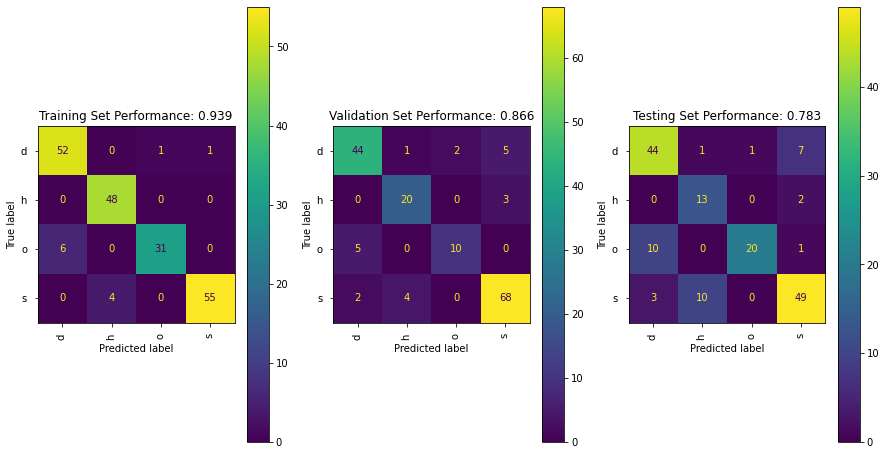

In [7]:
cknn = KNeighborsClassifier().set_params(**params1)
cknn.fit(x_train_std, y_train)
eval_model(cknn, x_train_std, y_train, x_val_std, y_val, x_test_std, y_test)

---
---
# 2. Random Forest

## Find the best params from val data (using GridSearchCV)

              precision    recall  f1-score   support

          d        0.80      0.74      0.76        53
          h        0.72      0.87      0.79        15
          o        0.92      0.74      0.82        31
          s        0.78      0.87      0.82        62

    accuracy                           0.80       161
   macro avg       0.81      0.80      0.80       161
weighted avg       0.81      0.80      0.80       161



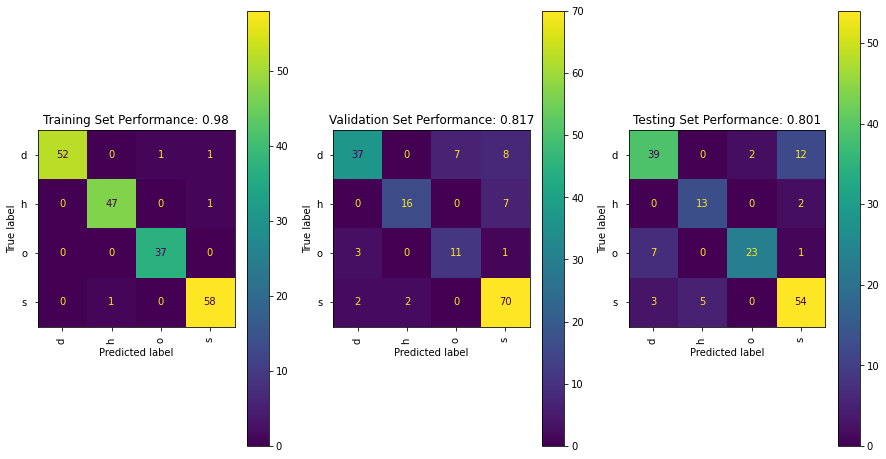

In [10]:
rf = RandomForestClassifier(n_estimators=123, max_depth=2, class_weight=None, random_state=42)
rf.fit(x_train_std, y_train)
eval_model(rf, x_train_std, y_train, x_val_std, y_val, x_test_std, y_test)

best params: {'class_weight': 'balanced_subsample', 'max_depth': 2, 'n_estimators': 191}
              precision    recall  f1-score   support

          d        0.80      0.70      0.75        53
          h        0.72      0.87      0.79        15
          o        0.86      0.81      0.83        31
          s        0.79      0.87      0.83        62

    accuracy                           0.80       161
   macro avg       0.80      0.81      0.80       161
weighted avg       0.80      0.80      0.80       161



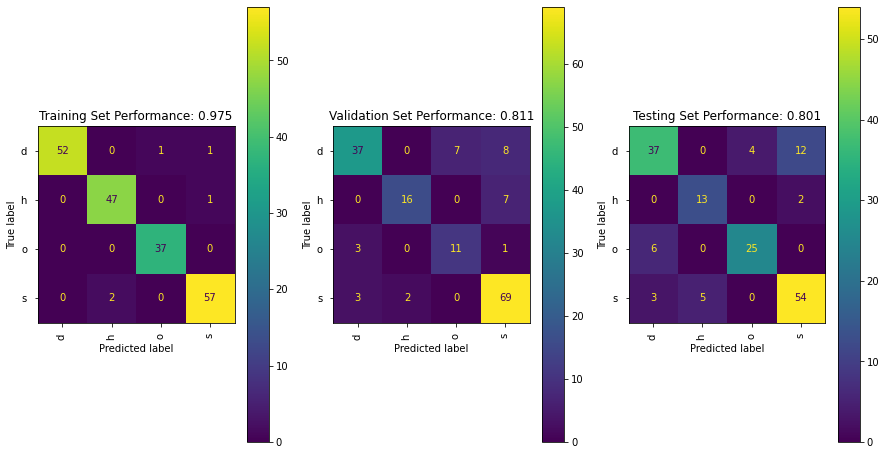

In [12]:
param_grid = [{
        'n_estimators': list(range(1,302,10)), 
        'max_depth': list(range(1,11)),
        'class_weight': ['balanced_subsample', None]
    }]

my_test_fold = [-1]*len(x_train_std) + [0]*len(x_val_std)
x_gridsearch = np.concatenate((x_train_std, x_val_std), axis=0)
y_gridsearch = np.concatenate((y_train, y_val), axis=0)
ps = PredefinedSplit(test_fold = my_test_fold)

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv = ps)
grid_search.fit(x_gridsearch, y_gridsearch)


best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print('best params:',params)
rf = RandomForestClassifier().set_params(**params)
rf.fit(x_train_std, y_train)
eval_model(rf, x_train_std, y_train, x_val_std, y_val, x_test_std, y_test)

### Refine search

In [13]:
param_grid = [{
        'n_estimators': list(range(182,190)), 
        'max_depth': list(range(1,4)),
        'class_weight': ['balanced_subsample', None]
    }]

my_test_fold = [-1]*len(x_train_std) + [0]*len(x_val_std)
x_gridsearch = np.concatenate((x_train_std, x_val_std), axis=0)
y_gridsearch = np.concatenate((y_train, y_val), axis=0)
ps = PredefinedSplit(test_fold = my_test_fold)

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv = ps)
grid_search.fit(x_gridsearch, y_gridsearch)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'class_weight': ['balanced_subsample', None],
                          'max_depth': [1, 2, 3],
                          'n_estimators': [182, 183, 184, 185, 186, 187, 188,
                                           189]}])

### Run

best params: {'class_weight': 'balanced_subsample', 'max_depth': 2, 'n_estimators': 184}
              precision    recall  f1-score   support

          d        0.80      0.70      0.75        53
          h        0.72      0.87      0.79        15
          o        0.86      0.81      0.83        31
          s        0.79      0.87      0.83        62

    accuracy                           0.80       161
   macro avg       0.80      0.81      0.80       161
weighted avg       0.80      0.80      0.80       161



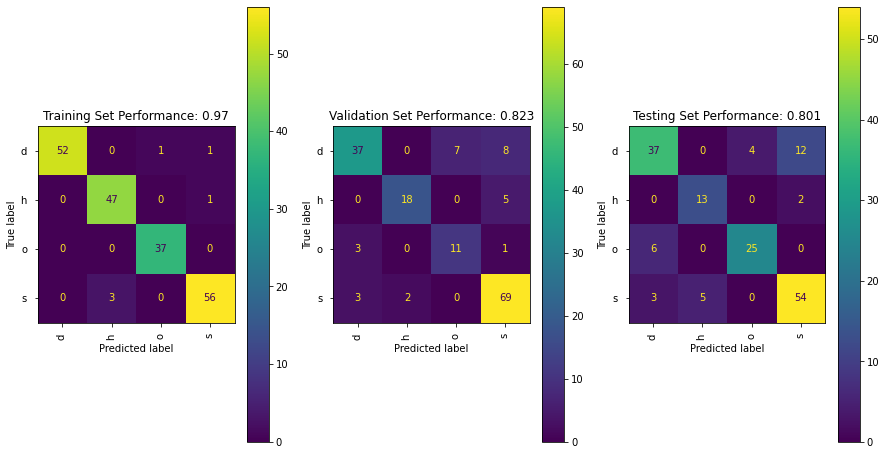

In [14]:
best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print('best params:',params)
rf = RandomForestClassifier().set_params(**params)
rf.fit(x_train_std, y_train)
eval_model(rf, x_train_std, y_train, x_val_std, y_val, x_test_std, y_test)

### Run with **class_weight=None**

              precision    recall  f1-score   support

          d        0.79      0.70      0.74        53
          h        0.72      0.87      0.79        15
          o        0.85      0.74      0.79        31
          s        0.78      0.87      0.82        62

    accuracy                           0.79       161
   macro avg       0.79      0.79      0.79       161
weighted avg       0.79      0.79      0.79       161



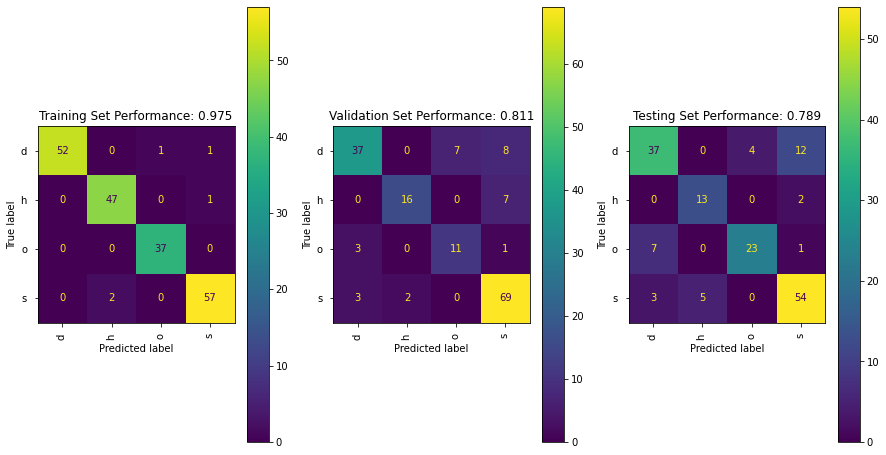

In [15]:
rf = RandomForestClassifier(n_estimators=184, max_depth=2, class_weight=None).fit(x_train, y_train)
eval_model(rf, x_train, y_train, x_val, y_val, x_test, y_test)

---
---
# 3. SVM

### Note: Scikit learn lib automatically sets the svm to a one-to-one encoding if it detect multi-classes.

## Find the best params from val data

best params: {'C': 0.1, 'class_weight': None, 'kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.88      0.85      0.87        53
          h        0.56      0.93      0.70        15
          o        0.93      0.81      0.86        31
          s        0.88      0.82      0.85        62

    accuracy                           0.84       161
   macro avg       0.81      0.85      0.82       161
weighted avg       0.86      0.84      0.84       161



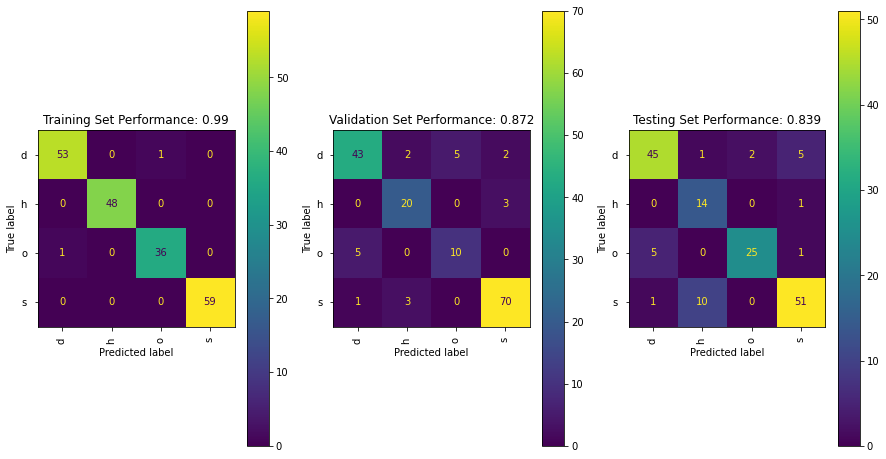

In [16]:
param_grid = [
  {'C': [0.01,0.1,1,10,100,1000], 'kernel': ['linear'], 'class_weight': ['balanced',None]},
  {'C': [0.01,0.1,1,10,100,1000], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf'], 'class_weight': ['balanced',None]},
  {'C': [0.01,0.1,1,10,100,1000], 'degree': [2,3,4,5,6,7], 'kernel': ['poly'], 'class_weight': ['balanced',None]},
]

my_test_fold = [-1]*len(x_train_std) + [0]*len(x_val_std)
x_gridsearch = np.concatenate((x_train_std, x_val_std), axis=0)
y_gridsearch = np.concatenate((y_train, y_val), axis=0)
ps = PredefinedSplit(test_fold = my_test_fold)

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv = ps)
grid_search.fit(x_gridsearch, y_gridsearch)


best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print('best params:',params)
svm = SVC().set_params(**params)
svm.fit(x_train_std, y_train)
eval_model(svm, x_train_std, y_train, x_val_std, y_val, x_test_std, y_test)

best params: {'C': 0.09490000000000014, 'class_weight': None, 'kernel': 'linear'}
              precision    recall  f1-score   support

          d        0.88      0.83      0.85        53
          h        0.56      0.93      0.70        15
          o        0.93      0.81      0.86        31
          s        0.86      0.82      0.84        62

    accuracy                           0.83       161
   macro avg       0.81      0.85      0.81       161
weighted avg       0.85      0.83      0.84       161



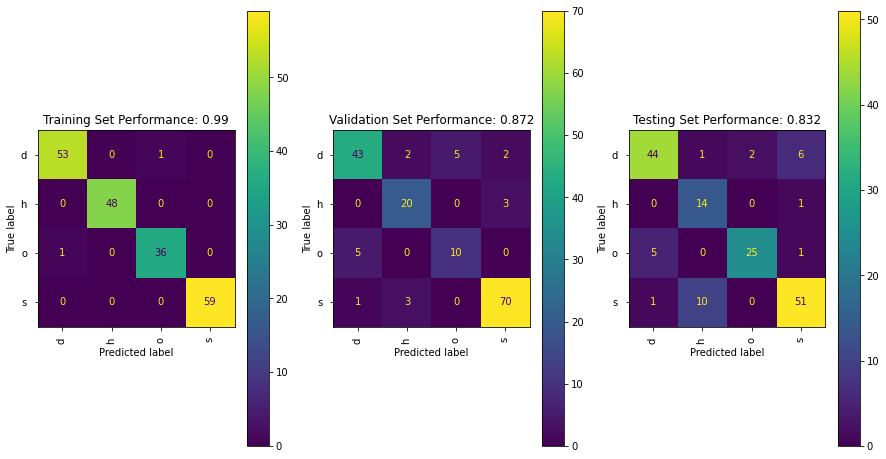

In [17]:
param_grid = [
    {'C': np.arange(0.09,0.11,0.0001), 'kernel': ['linear'], 'class_weight': ['balanced',None]}
]

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv = ps)
grid_search.fit(x_gridsearch, y_gridsearch)

best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print('best params:',params)

## Run

In [ ]:
svm = SVC().set_params(**params)
svm.fit(x_train_std, y_train)
eval_model(svm, x_train_std, y_train, x_val_std, y_val, x_test_std, y_test)

However, test result is higher with **'class_weight'=None**

              precision    recall  f1-score   support

          d        0.88      0.83      0.85        53
          h        0.56      0.93      0.70        15
          o        0.93      0.81      0.86        31
          s        0.86      0.82      0.84        62

    accuracy                           0.83       161
   macro avg       0.81      0.85      0.81       161
weighted avg       0.85      0.83      0.84       161



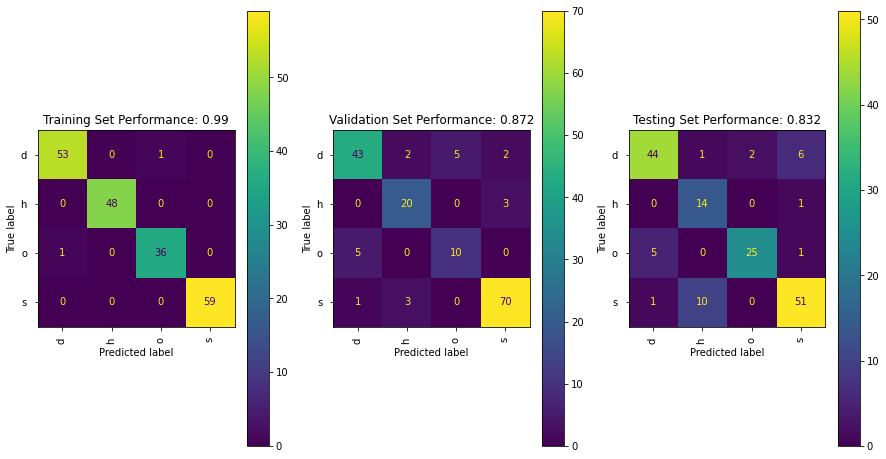

In [18]:
svm = SVC(C=0.0949, kernel='linear', class_weight=None)
svm.fit(x_train_std, y_train)
eval_model(svm, x_train_std, y_train, x_val_std, y_val, x_test_std, y_test)